# Análisis Semántico Latente
En este cuaderno se realizará la implementación del modelo de Analisis Semántico Latente (LSA) para los textos seleccionados dentro del corpus para compararlos con los manualmente generados y poder realizar un análisis sobre este.

Esta etapa esta compuesta de las siguientes fases:
1. Cargar datos.
2. Tokenizar por frases el corpus.
3. Aplicar el preprocesamiento al nuevo corpus.
4. Crear diccionarios para relacionar frases e identificadores.
5. Construir la matriz de A del Análisis Semántico Latente.
6. Determinar el número de temas.
    1. Seleccionar frases.
    2. Mostrar resumenes.
    3. Evaluar el resumen obtenido.
    4. Gráficas.
7. Determinar longitud del resumen.
    1. Seleccionar frases.
    2. Mostrar resumenes.
    3. Evaluar el resumen obtenido.
    4. Gráficas.

In [1]:
#Importar elementos necesarios de las librerías
import os, shutil, re, pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rouge import Rouge
from nltk.corpus import PlaintextCorpusReader
from nltk.stem.snowball import SpanishStemmer
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [2]:
#directorio actual
actual_dir = os.getcwd()

#Ruta del corpus
ruta = actual_dir + "\\textos"

#ruta de los resumenes de referencia
ruta_referencias = actual_dir + "\\referencias"

In [3]:
#Funciones auxiliares

def tokenize_sentence(path, file_name):
    #Retorna un documento tokenizado por frases
    doc = []
    text = PlaintextCorpusReader(path, file_name)
    paragraphs = text.paras()
    for paragraph in paragraphs:
        for sentence in paragraph:
            low, i = 0,0
            while i < len(sentence):
                token = sentence[i].split('.')
                if len(token)-1:
                    doc.append(sentence[low:i])
                    low=i+1
                    i+=2
                else:
                    i+=1
            if low!=i-1:
                doc.append(sentence[low:i])
    return doc

def preprocess(doc, stopwords, stemmer):
    #Aplica el preprocesamiento establecido
    #Adicionalmente, retorna el documento original sin las filas vacías por el preprocesamiento 
    doc_preprocesed, doc_reduced = [], []
    for original_sentence in doc:
        preprocessed_sentence = []
        for token in original_sentence:
            if stemmer.stem(token) not in stopwords:
                preprocessed_sentence.append(stemmer.stem(token))
        if len(preprocessed_sentence) and preprocessed_sentence not in doc_preprocesed:
            doc_preprocesed.append(preprocessed_sentence)
            doc_reduced.append(original_sentence)
    return doc_preprocesed, doc_reduced

def get_dictionaries(doc):
    #Retorna un par de diccionarios que relacionan una frase con un id, y un id con una frase.
    sentence2id, id2sentence = {},{}
    n_sentences = len(doc)
    for i in range(n_sentences):
        sentence = ' '.join(doc[i])
        if sentence not in sentence2id:
            sentence2id[sentence] = i
            id2sentence[i] = sentence
    return sentence2id, id2sentence

def getid2token(token2id):
    #Retorna un diccionario de tokens a id, a partir de un diccionario de id a tokens
    id2token ={}
    for k,v in token2id.items():
        id2token[v] = k
    return id2token

def build_A_Matrix(document, tf_idf, token2id, doc_id):
    #Construye la matriz A que recibe el modelo de LSA como entrada
    data,row_index,col_index = [],[],[]
    tf_idf = tf_idf.toarray()
    n,m = len(document), len(token2id)
    for i in range(n):
        sentence = document[i]
        j = 0
        for token in sentence:
            if token in token2id and tf_idf[doc_id,token2id[token]] != 0:
                if (j==0) or (j>0 and token2id[token] not in col_index[-j:]):
                    value = tf_idf[doc_id,token2id[token]]
                    tf_idf_value = value
                    data.append(tf_idf_value)
                    row_index.append(i)
                    col_index.append(token2id[token])
                    j+=1
    data = np.array(data)
    row_index = np.array(row_index)
    col_index = np.array(col_index)
    A_matrix = csr_matrix((data,(row_index,col_index)),shape=(n, m),dtype=np.float64)
    return A_matrix

def generate_summary(lsa, n_sentences, sentence2id):
    #Genera un resumen con n_sentences frases
    total_sentences,n_topics = lsa.shape
    assert n_sentences < total_sentences
    columns = ["topic {}".format(i) for i in range(n_topics)]
    df = pd.DataFrame(lsa,columns=columns)
    df['sentence'] = sentence2id.keys()
    summary = []
    for i in range(n_sentences):
        df = df.sort_values(by='topic {}'.format(i%n_topics), ascending = False)
        j = 0
        while j < total_sentences:
            sentence = df.iloc[j]['sentence']
            if sentence not in summary:
                summary.append(sentence)
                j=total_sentences
            else:
                j+=1
    return summary

def read_reference(path, filename):
    #Lee un resumen de referencia
    text = PlaintextCorpusReader(path, filename)
    text = text.paras()
    flat = []
    for sentences in text:
        for sentence in sentences:
            flat_sentence = ' '.join(sentence)
            flat.append(flat_sentence)
    reference = ' '.join(flat)
    return reference

## Fase 1. Cargar datos.
En esta fase se cargarán datos obtenidos durante el preprocesamientoy que utilizaremos para obtener el modelo de LSA.

In [4]:
#Cargar el modelo de tf-idf obtenido en preprocesamiento.
filename = 'tf-idf_model.pkl'
tf_idf = pickle.load(open(filename, 'rb'))

#Cargar la matriz de tf-idf obtenido en preprocesamiento.
filename = 'tf-idf_matrix.pkl'
tf_idf_matrix = pickle.load(open(filename, 'rb'))

#Cargar la matriz de tf-idf obtenido en preprocesamiento.
filename = 'stopwords.pkl'
stopwords = pickle.load(open(filename, 'rb'))

## Fase 2. Tokenizar las frases del corpus.
En esta fase se tokenizará por el corpus por frases.

In [5]:
stemmer = SpanishStemmer()
corpus = []

referencias = os.listdir(ruta_referencias)
n_referencias = len(referencias)

for doc in referencias:
    documento = tokenize_sentence(ruta, doc)
    corpus.append(documento)

## Fase 3. Aplicar el preprocesamiento al nuevo corpus.
En esta fase se aplicará el preprocesamiento establecido

In [6]:
corpus_preprocesado = []
for i in range(n_referencias):
    doc_preprocesado, corpus[i] = preprocess(corpus[i], stopwords, stemmer)
    corpus_preprocesado.append(doc_preprocesado)

## Fase 4. Crear diccionarios para relacionar frases e identificadores.
Con el fin de obtener un resumen luego de aplicar la técnica de LSA, se necesita relacionar una frase con un identificador único. Esta fase cumple con dicho objetivo.

In [7]:
frase2id, id2frase = [],[]

for i in range(n_referencias):
    f2id, id2f = get_dictionaries(corpus[i])
    frase2id.append(f2id)
    id2frase.append(id2f)

## Fase 5. Construir la matriz de A del Análisis Semántico Latente.
Hasta el momento, ya tenemos una lista de frases preprocesadas, ahora lo siguiente que tenemos que hacer es construir una matriz A de NxM, con N frases y M stemms. Para esto nos apoyaremos en el TF-IDF del preprocesamiento.

In [8]:
#Diccionario que relaciona tokens con un identificador único
token2id = tf_idf.vocabulary_

#Lista de textos dentro del corpus
textos = os.listdir(ruta)

matriz_A_corpus = []
for i in range(n_referencias):
    matriz_A_doc = build_A_Matrix(corpus_preprocesado[i], tf_idf_matrix, token2id, textos.index(referencias[i]))
    matriz_A_corpus.append(matriz_A_doc)

## Fase 6. Determinar el número de temas

In [9]:
#Número de temas en la matriz resultante
n_temas = [3,5,8]

lsa_por_temas = []
for i in range(len(n_temas)):
    #Instancia un modelo de LSA
    lsa_model = TruncatedSVD(n_components=n_temas[i])
    #Aplica el LSA a la matriz tf-idf
    lsa_corpus = []
    for j in range(n_referencias):
        lsa_doc = lsa_model.fit_transform(matriz_A_corpus[j])
        lsa_corpus.append(lsa_doc)
    lsa_por_temas.append(lsa_corpus)

## Fase 6.A Seleccionar frases.

In [10]:
resumenes = []
for i in range(n_referencias):
    resumenes_por_temas = []
    for j in range(len(n_temas)):
        resumen = generate_summary(lsa_por_temas[j][i],8,frase2id[i])
        resumen = '. '.join(resumen)
        resumenes_por_temas.append(resumen)
    resumenes.append(resumenes_por_temas)

## Fase 6.B Mostrar resumenes

In [11]:
for i in range(n_referencias):
    print(referencias[i])
    for j in range(len(n_temas)):
        print(n_temas[j])
        print(resumenes[i][j])
        print()
    print()

adobe-condiciones.txt
3
Si usted es un Usuario empresarial , acepta que , debido a la recepción de Derechos de dicha Compañía , ( 1 ) Adobe puede proporcionar a dicha Compañía la capacidad de usar , eliminar , retener y controlar su Perfil empresarial y todo su Contenido , o acceder a ellos , ya sean cargados o importados antes o luego de la fecha en que estas Condiciones se actualizaron por última vez ; ( 2 ) su uso de los Servicios y el Software se rige por el acuerdo de dicha Compañía con Adobe ; y ( 3 ) Adobe puede proporcionar su información personal a dicha Compañía. Ninguna de las partes será responsable ante la otra por cualquier retraso o incumplimiento de cualquier obligación ( excepto en el caso de sus obligaciones de pago con Adobe ) especificada en las Condiciones si el retraso o el incumplimiento se debe a eventos imprevistos que ocurran luego de la entrada en vigor de las Condiciones y que estén fuera del control razonable de las partes , como huelgas , bloqueo , guerra 

## Fase 6.C. Evaluar el resumen obtenido.

In [12]:
resumenes_referencia = []

for doc in referencias:
    referencia_doc = read_reference(ruta_referencias, doc)
    resumenes_referencia.append(referencia_doc)

rouge = Rouge(metrics=["rouge-1", "rouge-l"])

In [13]:
puntajes_corpus = [[] for _ in range(len(n_temas))]

for i in range(n_referencias):
    print(referencias[i])
    for j in range(len(n_temas)):
        print(n_temas[j])
        puntajes_documento = rouge.get_scores(resumenes[i][j], resumenes_referencia[i])
        puntajes_corpus[j].append(puntajes_documento)
        print(puntajes_documento)
    print()

adobe-condiciones.txt
3
[{'rouge-1': {'f': 0.5269624523459936, 'p': 0.5490753911806543, 'r': 0.5065616797900262}, 'rouge-l': {'f': 0.27288427828887285, 'p': 0.30038022813688214, 'r': 0.25}}]
5
[{'rouge-1': {'f': 0.5366197133366792, 'p': 0.5790273556231003, 'r': 0.5}, 'rouge-l': {'f': 0.3212435183579575, 'p': 0.35361216730038025, 'r': 0.29430379746835444}}]
8
[{'rouge-1': {'f': 0.5264643563552569, 'p': 0.5694656488549619, 'r': 0.489501312335958}, 'rouge-l': {'f': 0.35168738406266864, 'p': 0.4008097165991903, 'r': 0.31329113924050633}}]

adobe-privacidad.txt
3
[{'rouge-1': {'f': 0.5716463367389668, 'p': 0.46296296296296297, 'r': 0.7470119521912351}, 'rouge-l': {'f': 0.4477064171181551, 'p': 0.39228295819935693, 'r': 0.5213675213675214}}]
5
[{'rouge-1': {'f': 0.5705750513249163, 'p': 0.45639187574671447, 'r': 0.7609561752988048}, 'rouge-l': {'f': 0.43144423642056223, 'p': 0.3769968051118211, 'r': 0.5042735042735043}}]
8
[{'rouge-1': {'f': 0.5569434192970009, 'p': 0.4412107101280559, 'r': 

## Fase 6.D. Gráficas

In [14]:
metricas=['rouge-1','rouge-l']

puntajes_por_temas = []
for i in range(len(n_temas)):
    puntajes_por_metrica = [[],[]]
    for j in range(len(metricas)):
        for k in range(n_referencias):
            m = metricas[j]
            f_score = puntajes_corpus[i][k][0][m]['f']
            precision = puntajes_corpus[i][k][0][m]['p']
            recall = puntajes_corpus[i][k][0][m]['r']
            puntajes_por_metrica[j].append((f_score,precision,recall))
    puntajes_por_temas.append(puntajes_por_metrica)
    
metricas = ['f-score','precision','recall']

### Comparación Rouge-1

In [15]:
df_rouge1 = pd.DataFrame(puntajes_por_temas[0][0], columns=['f-score 3 temas','precision 3 temas','recall 3 temas'])
for i in range(1,len(n_temas)):
    tmp = pd.DataFrame(puntajes_por_temas[i][0],
                       columns=['f-score {} temas'.format(n_temas[i]),'precision {} temas'.format(n_temas[i]),
                                'recall {} temas'.format(n_temas[i])])
    df_rouge1 = df_rouge1.join(tmp)

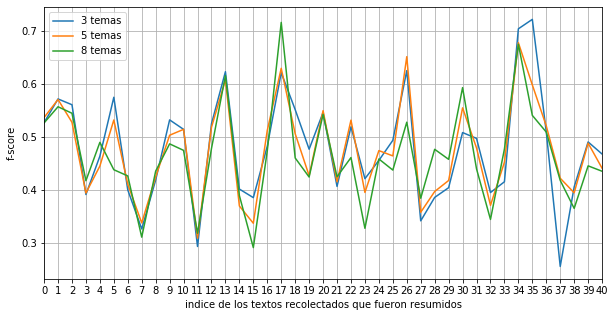

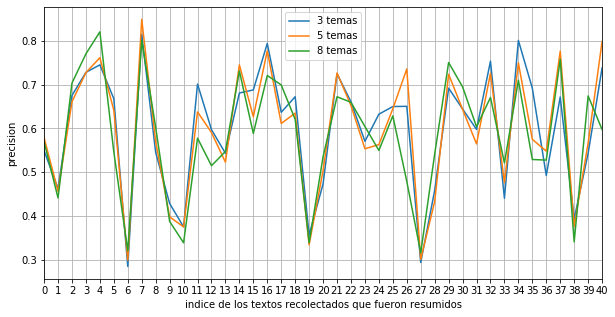

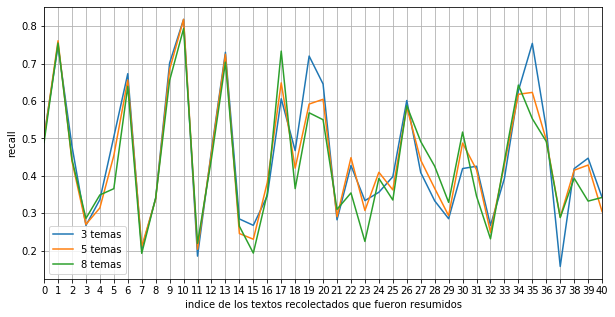

In [16]:
leyenda=['3 temas','5 temas','8 temas']
for metrica in metricas:
    grafica = df_rouge1.plot(y=['{} 3 temas'.format(metrica),'{} 5 temas'.format(metrica),'{} 8 temas'.format(metrica)],
                             figsize=(10,5),grid=1,layout=(1,3),xticks=np.arange(0,n_referencias,1))
    grafica.set_xlabel('indice de los textos recolectados que fueron resumidos')
    grafica.set_ylabel(metrica)
    grafica.legend(leyenda)

In [17]:
df_rouge1.describe()

,f-score 3 temas,precision 3 temas,recall 3 temas,f-score 5 temas,precision 5 temas,recall 5 temas,f-score 8 temas,precision 8 temas,recall 8 temas
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,0.478341,0.598175,0.451445,0.474818,0.596094,0.444528,0.463838,0.585567,0.432726
std,0.102122,0.139323,0.173401,0.089342,0.142616,0.159889,0.090616,0.136140,0.161006
min,0.255791,0.284567,0.157960,0.309073,0.298751,0.203947,0.291321,0.315603,0.192969
25%,0.404255,0.492386,0.333884,0.410561,0.522901,0.307438,0.424374,0.527697,0.332569
50%,0.482464,0.644599,0.419501,0.474227,0.611429,0.428899,0.458466,0.597647,0.393151
75%,0.532151,0.692053,0.601375,0.531667,0.726115,0.584192,0.509142,0.695122,0.550000
max,0.721713,0.814925,0.818182,0.677636,0.849398,0.818182,0.715976,0.820847,0.793388


### Comparación Rouge-L

In [18]:
df_rougel = pd.DataFrame(puntajes_por_temas[0][1], columns=['f-score 3 temas','precision 3 temas','recall 3 temas'])
for i in range(1,len(n_temas)):
    tmp = pd.DataFrame(puntajes_por_temas[i][1],
                       columns=['f-score {} temas'.format(n_temas[i]),'precision {} temas'.format(n_temas[i]),
                                'recall {} temas'.format(n_temas[i])])
    df_rougel = df_rougel.join(tmp)

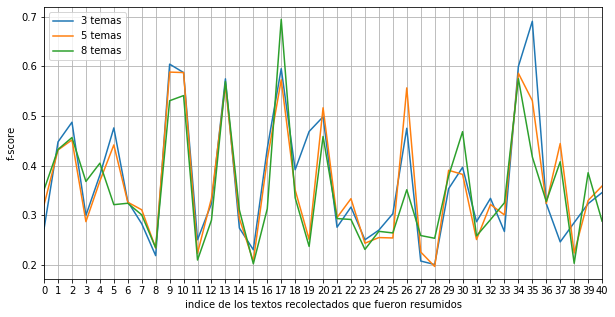

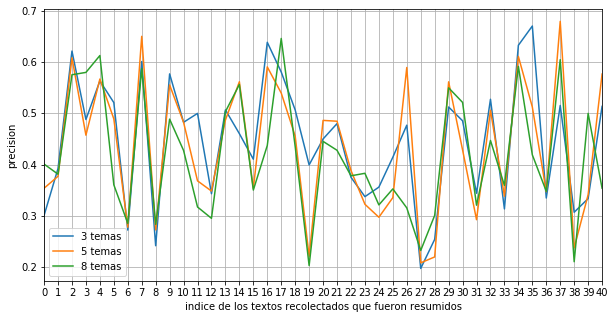

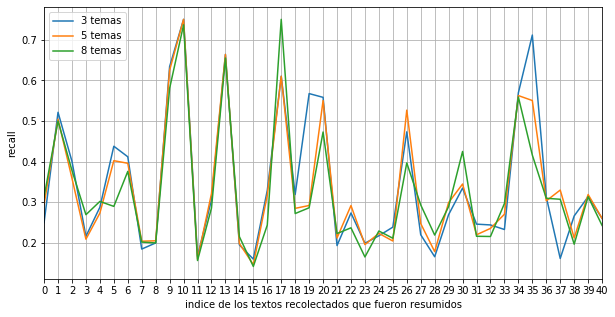

In [19]:
leyenda=['3 temas','5 temas','8 temas']
for metrica in metricas:
    grafica = df_rougel.plot(y=['{} 3 temas'.format(metrica),'{} 5 temas'.format(metrica),'{} 8 temas'.format(metrica)],
                             figsize=(10,5),grid=1,layout=(1,3),xticks=np.arange(0,n_referencias,1))
    grafica.set_xlabel('indice de los textos recolectados que fueron resumidos')
    grafica.set_ylabel(metrica)
    grafica.legend(leyenda)

In [20]:
df_rougel.describe()

,f-score 3 temas,precision 3 temas,recall 3 temas,f-score 5 temas,precision 5 temas,recall 5 temas,f-score 8 temas,precision 8 temas,recall 8 temas
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,0.370211,0.444807,0.343391,0.362856,0.433624,0.335602,0.351838,0.417202,0.326725
std,0.128207,0.120304,0.168812,0.119605,0.131371,0.154223,0.113202,0.118604,0.150742
min,0.200758,0.196721,0.160271,0.196891,0.207692,0.146727,0.202247,0.202381,0.142212
25%,0.274232,0.342857,0.217647,0.255034,0.338028,0.212366,0.267581,0.320988,0.219436
50%,0.323450,0.476923,0.273723,0.329670,0.455782,0.292135,0.324138,0.400810,0.289474
75%,0.468677,0.515464,0.437870,0.441558,0.555556,0.396000,0.407725,0.503401,0.378205
max,0.690554,0.670886,0.750000,0.588235,0.680000,0.750000,0.694444,0.646552,0.750000


## Fase 7. Determinar longitud del resumen.

In [21]:
#Se escoge realizar el resumen utilizando 3 temas, por eso se escoge el indice 0
indice_tema = 0

## Fase 7.A Seleccionar frases

In [22]:
resumenes = []
cantidad_frases_resumen = [5,8,10]

for i in range(n_referencias):
    resumenes_por_nfrases = []
    for cantidad_frases in cantidad_frases_resumen:
        resumen = generate_summary(lsa_por_temas[indice_tema][i],cantidad_frases,frase2id[i])
        resumen = '. '.join(resumen)
        resumenes_por_nfrases.append(resumen)
    resumenes.append(resumenes_por_nfrases)

## Fase 7.B Mostrar resumenes

In [23]:
for i in range(n_referencias):
    print(referencias[i])
    for j in range(len(cantidad_frases_resumen)):
        print('{} frases'.format(cantidad_frases_resumen[j]))
        print(resumenes[i][j])
        print()
    print()

adobe-condiciones.txt
5 frases
Si usted es un Usuario empresarial , acepta que , debido a la recepción de Derechos de dicha Compañía , ( 1 ) Adobe puede proporcionar a dicha Compañía la capacidad de usar , eliminar , retener y controlar su Perfil empresarial y todo su Contenido , o acceder a ellos , ya sean cargados o importados antes o luego de la fecha en que estas Condiciones se actualizaron por última vez ; ( 2 ) su uso de los Servicios y el Software se rige por el acuerdo de dicha Compañía con Adobe ; y ( 3 ) Adobe puede proporcionar su información personal a dicha Compañía. Ninguna de las partes será responsable ante la otra por cualquier retraso o incumplimiento de cualquier obligación ( excepto en el caso de sus obligaciones de pago con Adobe ) especificada en las Condiciones si el retraso o el incumplimiento se debe a eventos imprevistos que ocurran luego de la entrada en vigor de las Condiciones y que estén fuera del control razonable de las partes , como huelgas , bloqueo , 

## Fase 7.C Evaluar el resumen obtenido

In [24]:
puntajes_corpus = [[] for _ in range(len(cantidad_frases_resumen))]

for i in range(n_referencias):
    print(referencias[i])
    for j in range(len(cantidad_frases_resumen)):
        print(cantidad_frases_resumen[j])
        puntajes_documento = rouge.get_scores(resumenes[i][j], resumenes_referencia[i])
        puntajes_corpus[j].append(puntajes_documento)
        print(puntajes_documento)
    print()

adobe-condiciones.txt
5
[{'rouge-1': {'f': 0.46500401778167555, 'p': 0.6008316008316008, 'r': 0.37926509186351703}, 'rouge-l': {'f': 0.25868725392942865, 'p': 0.3316831683168317, 'r': 0.2120253164556962}}]
8
[{'rouge-1': {'f': 0.5269624523459936, 'p': 0.5490753911806543, 'r': 0.5065616797900262}, 'rouge-l': {'f': 0.27288427828887285, 'p': 0.30038022813688214, 'r': 0.25}}]
10
[{'rouge-1': {'f': 0.5454545404546237, 'p': 0.5476190476190477, 'r': 0.5433070866141733}, 'rouge-l': {'f': 0.28764804916957987, 'p': 0.3090909090909091, 'r': 0.2689873417721519}}]

adobe-privacidad.txt
5
[{'rouge-1': {'f': 0.609427604547552, 'p': 0.5276967930029155, 'r': 0.7211155378486056}, 'rouge-l': {'f': 0.45009784239352646, 'p': 0.4151624548736462, 'r': 0.49145299145299143}}]
8
[{'rouge-1': {'f': 0.5716463367389668, 'p': 0.46296296296296297, 'r': 0.7470119521912351}, 'rouge-l': {'f': 0.4477064171181551, 'p': 0.39228295819935693, 'r': 0.5213675213675214}}]
10
[{'rouge-1': {'f': 0.5232636502755027, 'p': 0.395514

## Fase 7.D Gráficas

In [25]:
metricas=['rouge-1','rouge-l']
puntajes_por_cantidad_de_frases = []

for i in range(len(cantidad_frases_resumen)):
    puntajes_por_metrica = [[],[]]
    for j in range(len(metricas)):
        for k in range(n_referencias):
            m = metricas[j]
            f_score = puntajes_corpus[i][k][0][m]['f']
            precision = puntajes_corpus[i][k][0][m]['p']
            recall = puntajes_corpus[i][k][0][m]['r']
            puntajes_por_metrica[j].append((f_score,precision,recall))
    puntajes_por_cantidad_de_frases.append(puntajes_por_metrica)
    
metricas=['f-score','precision','recall']

### Comparación Rouge-1

In [26]:
df_rouge1 = pd.DataFrame(puntajes_por_cantidad_de_frases[0][0], columns=['f-score 5 frases','precision 5 frases','recall 5 frases'])
for i in range(1,len(cantidad_frases_resumen)):
    tmp = pd.DataFrame(puntajes_por_cantidad_de_frases[i][0],
                       columns=['f-score {} frases'.format(cantidad_frases_resumen[i]),
                                'precision {} frases'.format(cantidad_frases_resumen[i]),
                                'recall {} frases'.format(cantidad_frases_resumen[i])])
    df_rouge1 = df_rouge1.join(tmp)

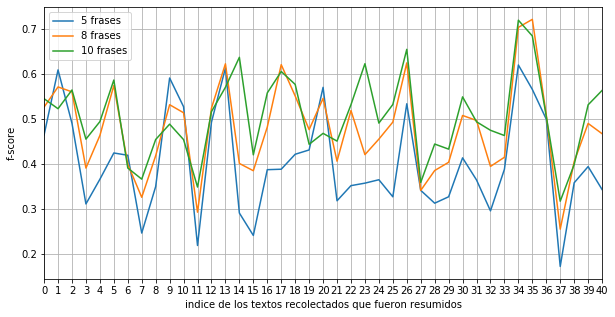

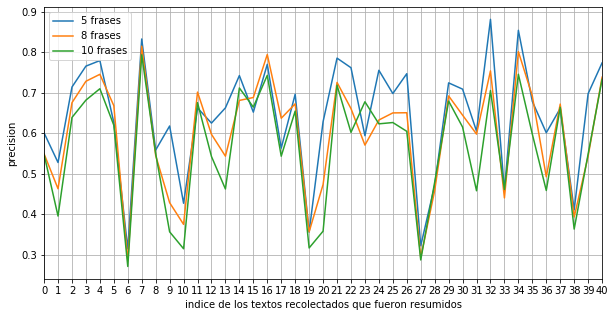

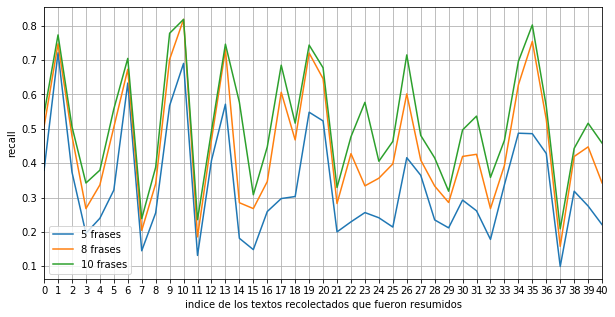

In [27]:
leyenda=['5 frases','8 frases','10 frases']
for metrica in metricas:
    grafica = df_rouge1.plot(y=['{} 5 frases'.format(metrica),'{} 8 frases'.format(metrica),'{} 10 frases'.format(metrica)],
                             figsize=(10,5),grid=1,layout=(1,3),xticks=np.arange(0,n_referencias,1))
    grafica.set_xlabel('indice de los textos recolectados que fueron resumidos')
    grafica.set_ylabel(metrica)
    grafica.legend(leyenda)

In [28]:
df_rouge1.describe()

,f-score 5 frases,precision 5 frases,recall 5 frases,f-score 8 frases,precision 8 frases,recall 8 frases,f-score 10 frases,precision 10 frases,recall 10 frases
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,0.403101,0.641760,0.332774,0.478341,0.598175,0.451445,0.505062,0.565828,0.516726
std,0.112392,0.140689,0.157507,0.102122,0.139323,0.173401,0.091273,0.143914,0.164998
min,0.172973,0.314136,0.099502,0.255791,0.284567,0.157960,0.317881,0.271104,0.208955
25%,0.327696,0.593870,0.221024,0.404255,0.492386,0.333884,0.451356,0.461111,0.405479
50%,0.387868,0.662252,0.292517,0.482464,0.644599,0.419501,0.494585,0.604651,0.496599
75%,0.490847,0.746914,0.415808,0.532151,0.692053,0.601375,0.563847,0.677670,0.677273
max,0.620330,0.881081,0.721116,0.721713,0.814925,0.818182,0.719831,0.793532,0.818182


### Comparación Rouge-L

In [29]:
df_rougel = pd.DataFrame(puntajes_por_cantidad_de_frases[0][1], columns=['f-score 5 frases','precision 5 frases','recall 5 frases'])
for i in range(1,len(cantidad_frases_resumen)):
    tmp = pd.DataFrame(puntajes_por_cantidad_de_frases[i][1],
                       columns=['f-score {} frases'.format(cantidad_frases_resumen[i]),
                                'precision {} frases'.format(cantidad_frases_resumen[i]),
                                'recall {} frases'.format(cantidad_frases_resumen[i])])
    df_rougel = df_rougel.join(tmp)

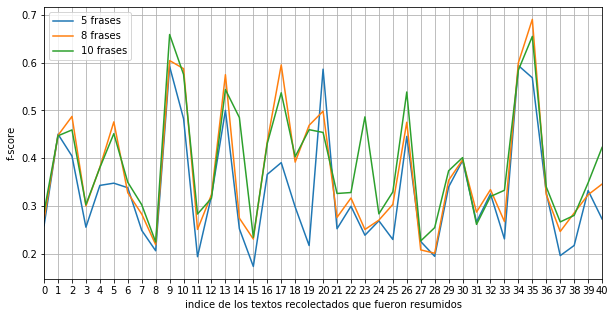

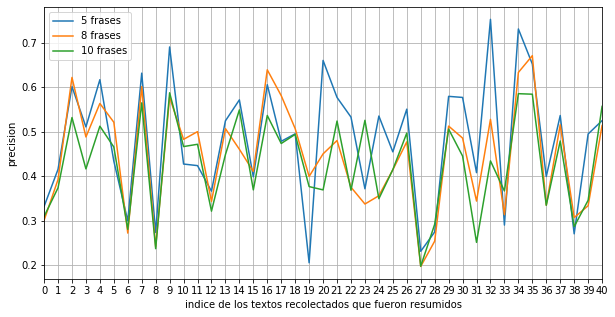

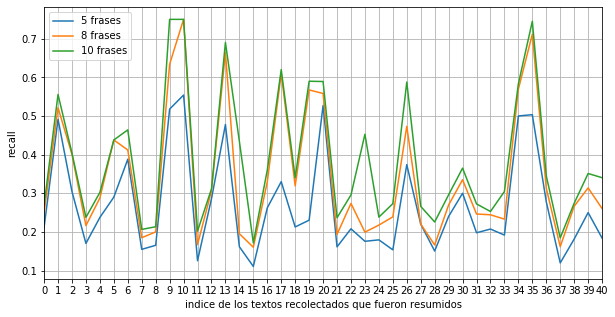

In [30]:
leyenda=['5 frases','8 frases','10 frases']
for metrica in metricas:
    grafica = df_rougel.plot(y=['{} 5 frases'.format(metrica),'{} 8 frases'.format(metrica),'{} 10 frases'.format(metrica)],
                             figsize=(10,5),grid=1,layout=(1,3),xticks=np.arange(0,n_referencias,1))
    grafica.set_xlabel('indice de los textos recolectados que fueron resumidos')
    grafica.set_ylabel(metrica)
    grafica.legend(leyenda)

In [31]:
df_rougel.describe()

,f-score 5 frases,precision 5 frases,recall 5 frases,f-score 8 frases,precision 8 frases,recall 8 frases,f-score 10 frases,precision 10 frases,recall 10 frases
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,0.327791,0.480471,0.267940,0.370211,0.444807,0.343391,0.388751,0.426621,0.385080
std,0.118104,0.140189,0.128240,0.128207,0.120304,0.168812,0.116684,0.105752,0.169584
min,0.173145,0.205000,0.110609,0.200758,0.196721,0.160271,0.224404,0.197279,0.171558
25%,0.238532,0.398374,0.175676,0.274232,0.342857,0.217647,0.302362,0.349138,0.266055
50%,0.299213,0.495050,0.220183,0.323450,0.476923,0.273723,0.349398,0.445122,0.340278
75%,0.390533,0.576923,0.304487,0.468677,0.515464,0.437870,0.459016,0.512195,0.464000
max,0.593814,0.752577,0.554054,0.690554,0.670886,0.750000,0.658824,0.587413,0.750000


## Fase 8. Exportar datos

In [32]:
#Guardar dataframe del ROUGE 1
filename = 'df_rouge1_LSA.pkl'
pickle.dump(df_rouge1, open(filename, 'wb'))

#Guardar dataframe del ROUGE L
filename = 'df_rougel_LSA.pkl'
pickle.dump(df_rougel, open(filename, 'wb'))

#Guardar resumenes
filename = 'resumenes_LSA.pkl'
pickle.dump(resumenes, open(filename, 'wb'))